# Calculating specific heat of dysprosium titanate against temperature

In [7]:
###Imports###
%matplotlib notebook

import numpy as np
import mpmath as mp
mp.dps = 15; mp.pretty = True
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import random

In [1]:
#####SINGLE MONOPOLE MODEL####

##function to compute physical values of single monopole spin ice system##

def single_monopole(start_mu, start_T, T_step, T_max, tol, limit):

    '''function to compute physical values of single monopole spin ice system
    Inputs:
    start_mu: the magnitude of the initial value of the chemical potential in kelvin
    start_T: the starting temperature in Kelvin
    T_step: iteration step of temperature
    T_max: the maximum temperature the function will run to
    tol: the convergence tolerance of the iterated chemical potentials
    limit: how many iterations on chemical potential the function will perform without achieving convergence'''
    
    ###constants###
    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    
    ##array initialisation##
    TempArray = []
    SpecHeatArray = []
    nArray = []
    muSingleArray = []
    freeEnergyArray= []
    internalEnergyArray = []
    l_DArray = []
    
    while T <= T_max :
        
        old_mu = 0
        new_mu = -start_mu * k_B
        init_mu = -start_mu * k_B
        beta = 1/(k_B * T)
        l_T = (mu_0 * Q * Q)/(k_B * T * 8 * np.pi)
        
        i=0
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            #new number of monopoles
            n = (4/3 * np.exp(beta * old_mu))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu))))
            #print("n:", n)
            
            #calculating new Debye length
            rho = n/vol_per_site
            #print("rho:", rho)
            l_D = np.sqrt((k_B * T)/(Q * Q * rho * mu_0)) #Deby length Calc
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = k_B * T * ((l_T)/(l_D + a))
            new_mu = init_mu + deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            i += 1
            if i==limit & limit != 1:
                print('Warning: Monopole density did not converge after',limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        ##Calculates the differential of monopole density n wit respect to Temperature, used to calculate specific heat
        differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * old_mu))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu))))), T)
        #differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * (init_mu + (k_B * t * ((l_T)/(l_D + a)))) ))/(1 +(1/3 * (4 * mp.exp((1/(k_B * t)) * (init_mu + (k_B * t * ((l_T)/(l_D + a)))) ))))), T)
        SpecHeatVal = - N_0 * (new_mu * float(differential))
        #print("differential of :", differential)
        #print("Specific Heat Value:", SpecHeatVal)
        
        #freeEnergy = (2 * new_mu * 2 * n) + ((Q*Q)/a)/(1 + a/l_D)
        fTerm3 = k_B*T*((n*np.log(n/2)) + ((1-n)*np.log(1-n)) + ((1-n)*np.log(2/3)))
        freeEnergy = -(new_mu + ((mu_0 * Q**2)/(4*np.pi*a)))*n + (l_D/a * deltaDH * n) + fTerm3
        
        #internalEnergyTerm = np.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        internalEnergy = - ((N_0 * k_B * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm
        
        muSingleArray= np.append(muSingleArray, new_mu)
        TempArray = np.append(TempArray, T)
        nArray = np.append(nArray,n)
        SpecHeatArray = np.append(SpecHeatArray, SpecHeatVal)
        freeEnergyArray = np.append(freeEnergyArray, freeEnergy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        l_DArray = np.append(l_DArray, l_D)
        T += T_step
        #print("done")
    
    ##numerical calculation of entropy, omega##
    DiffNumerical = np.gradient(nArray, T_step)
    SpecHeatNumerical = - 1/2 * N_0 * (muSingleArray * DiffNumerical)

    DeltaS = cumtrapz((SpecHeatNumerical)/TempArray, TempArray)
    DeltaS = np.insert(DeltaS,0,0, axis=0) #inserts a 0 in 0th element to match other arrays' sizes
    EntropyTotalArray = DeltaS + (N_0*1/2 * k_B *np.log(3/2))

    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (TempArray*EntropyTotalArray)
    print("")
    print("final")
    #print("Temperature values:", TempArray)
    #print("Specific Heat array:", SpecHeatArray)
    return (TempArray, SpecHeatArray, nArray, muSingleArray, freeEnergyArray, internalEnergyArray, l_DArray, SpecHeatNumerical, DeltaS, Omega, EntropyTotalArray)

In [62]:
def free_energy_single(mu, T, n_start, n_step, n_max):
    
    #constants#
    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    n = n_start
    
    #array initialisation#
    nArray = []
    OmegaArray = []
    
    while n <= n_max:
        #rho = n/vol_per_site
        #l_D = np.sqrt((k_B * T)/(Q * Q * rho * mu_0)) #Debye length Calc
        
        #internalEnergyTerm = np.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        #internalEnergy = - ((N_0 * k_B * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm #Total internal energy
        internalEnergy = - ((4 * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm #per site internal energy in Kelvin
        
        #Entropy = -k_B*N_0*( (n*np.log(n/2)) + ((1-n)*np.log(1-n)) + ((1-n)*np.log(2/3)) ) #Total entropy
        Entropy = -( (n*np.log(n/2)) + ((1-n)*np.log(1-n)) + ((1-n)*np.log(2/3)) ) #entropy per site w/out k_B
        
        #Omega = internalEnergy - (-mu*k_B * (N_0*n)) - (T*Entropy) #total free energy
        Omega = internalEnergy - (-mu*n) - (T*Entropy) #free energy per site in Kelvin
        
        nArray = np.append(nArray, n)
        OmegaArray = np.append(OmegaArray, Omega)
        
        n+=n_step
        
    return(nArray, OmegaArray)

In [ ]:
###4.35 mu values###
TempArray, SpecHeatArray, nArray, muSingleArray, freeEnergyArray, internalEnergyArray, l_DArray, SpecHeatNumerical, DeltaS, Omega, EntropyTotalArray = single_monopole(4.35, 0.1, 0.001, 2, 1e-4, 1)

###1.928 mu values###
TempArray2, SpecHeatArray2, nArray2, muSingleArray2, freeEnergyArray2, internalEnergyArray2, l_DArray2, SpecHeatNumerical2, DeltaS2, Omega2, EntropyTotalArray2 = single_monopole(1.928, 0.1, 0.001, 2, 1e-4, 1)

###10 mu values###
TempArray3, SpecHeatArray3, nArray3, muSingleArray3, freeEnergyArray3, internalEnergyArray3, l_DArray3, SpecHeatNumerical3, DeltaS3, Omega3, EntropyTotalArray3 = single_monopole(4.35*2, 0.1, 0.001, 2, 1e-4, 1)

In [65]:
###4.350 mu###
nArray_TempStatic, OmegaArray_TempStatic = free_energy_single(4.350, 0.191, 10**-8, 10**-5, 10**0)

###1.928 mu###
nArray_TempStatic2, OmegaArray_TempStatic2 = free_energy_single(1.570, 0.191, 10**-8, 10**-5, 10**0)

###8.700 mu###
nArray_TempStatic3, OmegaArray_TempStatic3 = free_energy_single(8.700, 0.191, 10**-8, 10**-5, 10**0)

In [90]:
###1.928 mu###
nArray_TempStatic2, OmegaArray_TempStatic2 = free_energy_single(1.570, 0.1505, 10**-8, 10**-8, 10**-4)

In [91]:
###1.928 mu###
nArray_TempStatic4, OmegaArray_TempStatic4 = free_energy_single(1.570, 0.1505, 10**-4, 10**-4, 10**-0)

In [ ]:
print(nArray_TempStatic)

In [ ]:
#####DEFUNCT, MOVED TO FUNCTION######
###testing Kaiser eqn.3###
vol_per_site = ((10.1**3)/8) * 10**-30
N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
k_B = 1.38064852 * 10**-23 #Boltzmann constant

###Spec Heat via gradient###
DiffNumerical = np.gradient(nArray, 0.001)
SpecHeat = - 1/2 * N_0 * (muSingleArray * DiffNumerical)

DeltaS = cumtrapz((SpecHeat)/TempArray, TempArray)
DeltaS = np.insert(DeltaS,0,0, axis=0)

Omega = internalEnergyArray - (-4.35*k_B * (N_0* nArray)) - (TempArray*DeltaS)

<IPython.core.display.Javascript object>


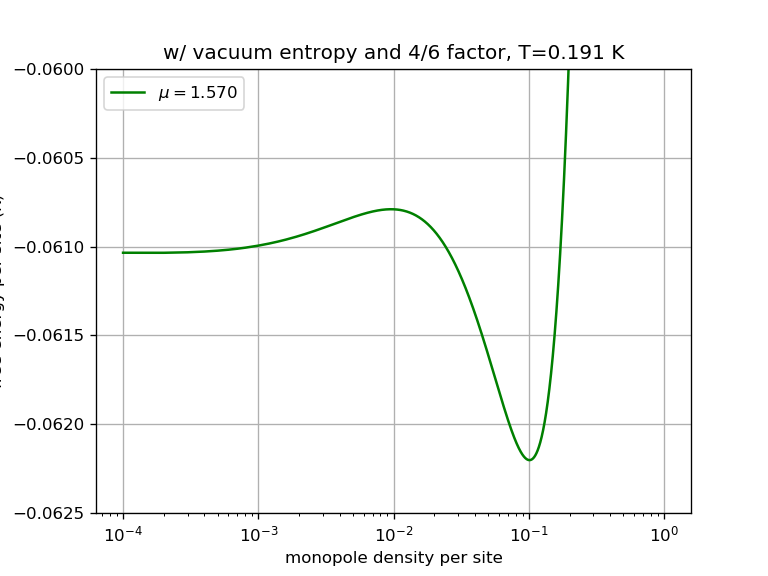

In [95]:
###monopole density against Temperature###
k_B = 1.38064852 * 10**-23 #Boltzmann constant

MonopoleDensityGraph1 = plt.figure()
plt.grid(True)
#plt.plot(1/TempArray, np.log10(nArray/2), "b--", )
#plt.plot(nArray_TempStatic, OmegaArray_TempStatic, 'b-', label="$\mu=4.350$")
#plt.plot(nArray_TempStatic2, OmegaArray_TempStatic2, 'r-', label="$\mu=1.570$")
#plt.plot(nArray_TempStatic3, OmegaArray_TempStatic3, 'g-', label="$\mu=8.700$")
plt.plot(nArray_TempStatic4, OmegaArray_TempStatic4, 'g-', label="$\mu=1.570$")
plt.xlabel("monopole density per site")
plt.xscale('log')
#plt.xlim(10**-3, 10**-0)
plt.ylim(-0.0625,-0.06)
plt.ylabel("free energy per site (K)")
plt.title("w/ vacuum entropy and 4/6 factor, T=0.1505 K")
plt.legend(loc='upper left')
#plt.savefig('second Kaiser eqn3 comparison with vacuum entropy and 4 on 6 internal energy factor T=0.191 K.pdf')

In [ ]:
###monopole density against Temperature###
MonopoleDensityGraph1 = plt.figure()
plt.grid(True)
#plt.plot(1/TempArray, np.log10(nArray/2), "b--", )
#plt.plot(TempArray, nArray, 'b-', label="$\mu=4.35")
#plt.plot(TempArray2, nArray2, 'r-', label="$\mu=1.928")
plt.plot(TempArray3, nArray3, 'g-', label="$\mu=8.70")
plt.xlabel("Temperature /K")
plt.ylabel("monopole density per site")
plt.title("Comparison of monopole densities against Temperature")
plt.legend(loc='upper left')

In [ ]:
###Free Energy Check 4.35mu###
FreeEnergyGraph1 = plt.figure()
plt.grid(True)
#lt.plot(1/TempArray, np.log10(nArray/2), "b--", )
plt.plot(TempArray, Omega + (TempArray*DeltaS), 'b-', label="No TS contribution")
plt.plot(TempArray, - (TempArray*EntropyTotalArray), 'r-', label="-TS term")
plt.plot(TempArray, Omega, 'g-', label="Omega, Kaiser")
plt.plot(TempArray, freeEnergyArray, label="modified free energy, Arroo")
plt.xlabel("Temperature /K")
plt.ylabel("Energy /J")
plt.title("$\mu=4.35$ Comparison of free energies and components against Temperature")
plt.legend(loc='upper left')

In [ ]:
###Free Energy Check 1.928mu###
FreeEnergyGraph2 = plt.figure()
plt.grid(True)
#lt.plot(1/TempArray, np.log10(nArray/2), "b--", )
plt.plot(TempArray2, Omega2 + (TempArray2*DeltaS2), 'b-', label="No TS contribution")
plt.plot(TempArray2, - (TempArray2*DeltaS2), 'r-', label="-TS term")
plt.plot(TempArray2, Omega2, 'g-', label="Omega, Kaiser")
plt.plot(TempArray2, freeEnergyArray2, label="modified free energy, Arroo")
plt.xlabel("Temperature /K")
plt.ylabel("Energy /J")
plt.title("$\mu=1.928$ Comparison of free energies and components against Temperature")
plt.legend(loc='upper left')

In [ ]:
###Free Energy Check 8.70 mu###
N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
k_B = 1.38064852 * 10**-23 #Boltzmann constant

FreeEnergyGraph1 = plt.figure()
plt.grid(True)
#lt.plot(1/TempArray, np.log10(nArray/2), "b--", )
#plt.plot(TempArray3, Omega3 + (TempArray3*DeltaS3), 'b-', label="No TS contribution")
plt.plot(TempArray3, - (TempArray3*DeltaS3), 'r-', label="-TS term")
plt.plot(TempArray3, Omega3, 'g-', label="Omega, Kaiser")
plt.plot(TempArray3, internalEnergyArray3, label='internal energy')
plt.plot(TempArray3, muSingleArray3, label='mu array')
plt.plot(TempArray3, 10*k_B*N_0*nArray3, label='$\mu$N')
plt.plot(TempArray3, freeEnergyArray3, label="modified free energy, Arroo")
plt.xlabel("Temperature /K")
plt.ylabel("Energy /J")
plt.title("$\mu=8.70$ Comparison of free energies and components against Temperature")
plt.legend(loc='upper left')

In [ ]:
print(l_DArray3)

In [ ]:
atemp = 4.34 * 10**-10 #lattice spacing of diamond lattice
iEterm = np.log(1+atemp/l_DArray3) - (atemp/l_DArray3) + 1/2*((atemp/l_DArray3)**2)*0

FreeEnergyGraph1 = plt.figure()
plt.plot(iEterm)
plt.show()

In [ ]:
###Comparison between different mu and their free energy against monopole concentration###
FreeEnergyAgainstMonopoleGraph1 = plt.figure()
plt.grid(True)
plt.plot(nArray, Omega, "r-", label='4.350mu free energy' )
plt.plot(nArray2, Omega2, "g-", label='1.928mu free energy')
plt.plot(nArray3, Omega3, "b-", label='8.70mu free energy')
plt.xlabel("monopole density per site")
plt.ylabel("Free energy /J")
plt.title('Free energy against monopole concentration')
plt.legend(loc="upper right")
#plt.plot(nArray, Omega, "g--", )

In [ ]:
print((-4.35*k_B * (N_0* nArray)))

In [ ]:
print(internalEnergyArray)

In [ ]:
FGraph = plt.figure()
plt.grid(True)
#lt.plot(1/TempArray, np.log10(nArray/2), "b--", )
plt.plot(TempArray, SpecHeat)

In [ ]:
SanGraph2 =plt.figure()
plt.grid(True)
plt.plot(TempArray, DeltaS)

In [ ]:
print(DeltaS)

In [ ]:
###Single + Double monopole model###
def Double_monopole(start_mu, start_mu_2, start_T, T_step, T_max, tol, limit):

    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    
    ##array initialisation##
    TempArray_double = []
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    while T <= T_max :
        
        i = 0
        old_mu = 0
        new_mu = -start_mu * k_B
        init_mu = -start_mu * k_B
        old_mu_2 = 0
        new_mu_2 = -start_mu_2 * k_B
        init_mu_2 = -start_mu_2 * k_B
        beta = 1/(k_B * T)
        l_T = (mu_0 * Q * Q)/(k_B * T * 8 * np.pi)
        print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new number of monopoles
            n = (4/3 * np.exp(beta * old_mu))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu) + np.exp(beta * old_mu_2))))
            n_2 = (1/3 * np.exp(beta * old_mu_2))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu) + np.exp(beta * old_mu_2))))
            #print("n:", n)
            
            #calculating new Debye length
            rho = n/vol_per_site
            rho_2 = n_2/vol_per_site
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            l_D = np.sqrt((k_B * T)/(Q * Q * rho_I * mu_0)) #Debye length Calc
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = k_B * T * ((l_T)/(l_D + a))
            new_mu = init_mu + deltaDH
            new_mu_2 = init_mu_2 + 4*deltaDH
            #print("deltaDH:",deltaDH)
            print("mu:", new_mu)
            print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after 1000 iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        ##Calculates the differential of monopole density n wit respect to Temperature, used to calculate specific heat
        differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * old_mu))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu) + mp.exp((1/(k_B * t)) * old_mu_2) )))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu) + mp.exp((1/(k_B * t)) * old_mu_2) )))), T)
        #differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * (init_mu + (k_B * t * ((l_T)/(l_D + a)))) ))/(1 +(1/3 * (4 * mp.exp((1/(k_B * t)) * (init_mu + (k_B * t * ((l_T)/(l_D + a)))) ))))), T)
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        print("differential of n wrt T:", differential)
        print("differential of n_2 wrt T:", differential_2)
        print("Specific Heat Value:", SpecHeatVal)
        
        Entropy = - k_B * N_0 *( (n*np.log(n/2) + (n_2*np.log(2*n_2) + ((1-n-n_2)*np.log(1-n-n_2)) + ((1-n-n_2)*np.log(2/3)) ) ) )
        #Entropy_corrected = Entropy - (8.314 * 1/2*np.log(3/2))
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        TempArray_double = np.append(TempArray_double, T)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        T += T_step
        print("done")
    print("")
    print("final")
    print("Temperature values:", TempArray_double)
    print("Specific Heat array:", SpecHeatArray_double)
    return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array)

In [ ]:
test2= Double_monopole(4.35, 4*4.35, 0.1, 0.1, 30, 1e-5, 1000)
